In [27]:
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
ext = '0.4.0-oneiric1_amd64.deb -qO'
!wget $url/libta-lib0_$ext libta.deb
!wget $url/ta-lib0-dev_$ext ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib


!pip install tqdm
!pip install --upgrade mplfinance
!pip install transformers

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'dpkg' is not recognized as an internal or external command,
operable program or batch file.


In [41]:
%matplotlib inline
import pandas as pd
import mplfinance as mpf
import numpy as np
import talib as ta
from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import copy

import pickle
import transformers as ppb

import warnings
warnings.filterwarnings('ignore')


class LoadFile():
    def __init__(self):
        self.data = pd.read_csv('./APPLE.csv', delimiter=',', index_col="Date", parse_dates=True)
        self.data['%K'], self.data['%D'] = self.stochastic()
        self.data['SMA-10'] = self.simpleMovingAverage(window=10)
        self.data['SMA-30'] = self.simpleMovingAverage(window=30)
        self.data['MACD'], self.data['MACD_Signal'], self.data['MACD_Hist']  = self.MACD(12, 26)
        self.data['RSI'] = self.RSI(14)

    def fillNanData(self, data, column_name):
        data[column_name] =  data[column_name].replace(np.nan, data[column_name].mean())
        # data[column_name] =  data[column_name].replace(np.nan, data["Adj Close"].mean())
        # data[column_name] =  data[column_name].replace(np.nan, 0)
        return data
      
    def dataSplit(self, start, end):
        return self.data.loc[start:end, :]

    def stochastic(self, window = 14, window_1 = 3):
        k, d = ta.STOCH(self.data['High'], self.data['Low'], self.data['Close'], fastk_period= window, slowk_period= window_1, slowk_matype=0, slowd_period= window_1, slowd_matype=0)
        return k, d

    def MACD(self, fast_window = 12, slow_window = 26):
        macd, macdsignal, macdhist = ta.MACD(self.data['Close'], fastperiod= fast_window, slowperiod= slow_window, signalperiod=9)
        return macd, macdsignal, macdhist

    def RSI(self, window):
        return ta.RSI(self.data['Close'], timeperiod= window)

    def simpleMovingAverage(self, window):
        return ta.SMA(self.data['Close'], timeperiod=window)

    def chart(self, start, end, title, scale = 2):
        info = self.data.loc[start: end, :]
        plots = {
            'SMA-10': mpf.make_addplot((info[['SMA-10']]), panel=0, color='#f48c06'),
            'SMA-30': mpf.make_addplot((info[['SMA-30']]), panel=0, color='#0096c7'),
            '%K': mpf.make_addplot((info[['%K']]), ylim=[-5,120], panel=1, ylabel = "Stoch", color="#19B1E5"),
            '%D': mpf.make_addplot((info[['%D']]), panel=1, color='#F78D29'),
            'MACD': mpf.make_addplot((info[['MACD']]), panel=2, ylabel = "MACD"),
            'MACD_Signal': mpf.make_addplot((info[['MACD_Signal']]), panel=2, color='#f48c06'),
            'MACD_Hist': mpf.make_addplot((info[['MACD_Hist']]), panel=2, color="r"),
            'RSI': mpf.make_addplot((info[['RSI']]), panel=3, ylabel = "RSI")
        }
        fig, axes = mpf.plot(info, type='candle', style='yahoo', addplot= list(plots.values()) , volume=True, volume_panel=4, figscale= scale, title = f'{title} AAPL {start}-{end}', returnfig=True)
        axes[0].legend(labels=['Moving Average 10 days', 'Moving Average 30 days'], loc='upper right', fontsize='x-small')
        axes[2].legend(labels=['K', 'D'], loc='upper right', fontsize='x-small')
        axes[4].legend(labels=["MACD"], loc='upper right', fontsize='x-small')

    '''
        Extract inforamtion from news
        type_extraction = ['title', 'content', 'title-content' ]
    '''
    def load_news(self, type):
        
        file = open('./APPLE_news.pkl', 'rb')
        data = pickle.load(file)
        file.close()

        self.data_News = self.data_news_extraction(data, type)


    def data_news_extraction(self, data, type = 'title-content'):
        if type == 'title':
            return self.extract_title(data)
        elif type == 'content':
            return self.extract_Content(data)
        elif type == 'title-content':
            return self.extract_Title_Content(data)


    def extract_title(self,data):
        t = []
        for i in data:
            t.append([i[1],i[2]])
        
        m = pd.DataFrame(t, columns=['date', 'title'])
        m = m.set_index(['date'])
        m.index = pd.to_datetime(m.index)
        return m
    
    
    def extract_Content(self,data):
        t = []
        for i in data:
            t.append([i[1],i[3]])

        m = pd.DataFrame(t, columns=['date', 'content'])
        m = m.set_index(['date'])
        m.index = pd.to_datetime(m.index)
        return m

    def extract_Title_Content(self, data):
        t = []
        for i in data:
          join = f'{i[2]}: {i[3]}'
          t.append([i[1], join ])
        m = pd.DataFrame(t, columns=['date', 'title-content'])
        m = m.set_index(['date'])
        m.index = pd.to_datetime(m.index)
        return m

    def dataSplitNews(self, start, end):
        return self.data_News.loc[start:end, :]

    '''
        Fill missing value with a blank space
    '''
    def fillNanDataNews(self, data, column_name):
      data[column_name] =  data[column_name].replace(np.nan, ' ')
      return data

    def initBert(self):
        ''' For DistilBERT: samller, faster, cheaper, lighter 40% less parameters than bert-base-uncased
            run 60% faster
            95% of BERT's performance as meassured on the GLUE language understanding benchmark. 
        '''
        # Create tuple for DistilBERT:
        model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
        # Load pretrained model andtokenizer
        self.tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
        self.bert = model_class.from_pretrained(pretrained_weights)

    def embeddings_pretrain_BERT(self, data):
        '''Use tokenizer to include special tokens into the text
            [CLS] at the beginning and [SEP] for separating among 
            sentences.
        '''
        tokenized = data.apply((lambda x: self.tokenizer.encode(
            x, # Sentence to encode.
            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
            # padding = "max_length",
            # This function also supports truncation and conversion
            # to pytorch tensors, but we need to do padding, so we
            # can't use these features :( .
            # max_length = 64,          # Truncate all sentences.
            # return_tensors = 'pt',     # Return pytorch tensors.
        )))

        # print(tokenizer.convert_ids_to_tokens(tokenized[190]))

        '''Padding process based on max length of the token
           fill with zeros the empty spaces to have all 
           of the tokens of the same size
        '''
        max_len = 0
        for i in tokenized.values:
            if len(i) > max_len:
                max_len = len(i)

        padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

        ''' Create attention mask--> 
            new array to differentiate the tokenid 
            with padding. for token id = 1 and 
            for the padding = 0
        '''

        attention_mask = np.where(padded != 0, 1, 0)

        '''convert into torch tokenized and attention_mask'''
        input_ids = torch.tensor(padded)  
        attention_mask = torch.tensor(attention_mask)

        '''
        Get the embedding from BERT Model
        '''
        with torch.no_grad():
            last_hidden_states = self.bert(input_ids, attention_mask = attention_mask)
            return last_hidden_states[0][:,0,:].numpy()

    '''
    Join the emddings gotten from title and BERT model with the financial indices
    previously defined
    return a new Data Frame
    '''
    def join_data_bert(self, data, bert, column):
        
        date = data.index.to_numpy()
        data1 = data.loc[:, data.columns != column]
        newPD = pd.DataFrame(pd.to_datetime(date), columns=['Date'])
        newPD = newPD.join(pd.DataFrame(bert))
        newPD = newPD.set_index(['Date'])

        return  data1.join(newPD)

'''
Definition of the RNN model class
'''        
class RNNModel(nn.Module):
        def __init__(self,input_size, hidden_size, layer_size, output_size, device, dropout = 0 ):
            super(RNNModel, self).__init__()
            self.device = device
            # Hidden dimensions
            self.hidden_size = hidden_size
            # input dimensions
            self.layer_size = layer_size

            # Building RNN
            # (batch_size, time_step, input_size)
            # batch_size = number of samples per batch
            self.rnn = nn.RNN(
                input_size = input_size, # number of features
                hidden_size = hidden_size, 
                num_layers = layer_size, 
                batch_first = True, 
                nonlinearity = 'relu',
                dropout = dropout)
            
            # hidden_size is the in_features
            self.fc = nn.Linear(hidden_size, output_size)

        def forward(self, x):

            # x(batch, time_step, input_size)
            # h_state(n_layers, batch, hidden_size)
            # r_out(batch, time_step, output_size)
            # Initialize hidden state with zeros
            h0 = Variable(torch.zeros(self.layer_size, x.size(0), self.hidden_size))
            if self.device != 'cpu':
              h0 = h0.to(self.device)
            # One time step
            out, hn = self.rnn(x, h0)
            out = self.fc(out[:, -1, :]) 
            return out

            
'''
Definition of the LSTM model class
'''
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, device, dropout = 0):
        super(LSTMModel, self).__init__()

        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size = input_size, 
            hidden_size= hidden_size,
            num_layers = num_layers,
            batch_first = True,
            dropout = dropout)

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):

        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # hidden state
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # internal state
        if self.device != 'cpu':
          h0 = h0.to(self.device)
          c0 = c0.to(self.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

'''
Definition of the GRU model class
'''
class GRUModel(nn.Module):
        def __init__(self,input_size, hidden_size, num_layers , output_size, device, dropout = 0):
            super(GRUModel, self).__init__()

            self.device = device

            # Hidden dimensions
            self.hidden_size = hidden_size
            # input dimensions
            self.num_layers  = num_layers 

            # Building RNN
            # (batch_size, time_step, input_size)
            # batch_size = number of samples per batch
            self.gru = nn.GRU(
                input_size = input_size, # number of features
                hidden_size = hidden_size, 
                num_layers = num_layers , 
                batch_first = True, 
                dropout = dropout)
            
            # hidden_size is the in_features
            self.fc = nn.Linear(hidden_size, output_size)

        def forward(self, x):

            # x(batch, time_step, input_size)
            # h_state(n_layers, batch, hidden_size)
            # r_out(batch, time_step, output_size)
            # Initialize hidden state with zeros
            h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
            if self.device != 'cpu':
              h0 = h0.to(self.device)
            # One time step
            out, hn = self.gru(x, h0)
            out = self.fc(out[:, -1, :]) 
            return out

'''
Definition of the class to perform all of the calculations 
related to the training, validation, and test dataset
'''
class RNN():
    def __init__(self, train, validate, test,  timestep=30, learning_rate = 1e-4, hidden_size = 2, layer_size=2, batch_size = 5, epoch = 2, device = 'gpu', model= 'rnn', dropout = 0, weight_decay= 0):

        self.device =  self.getDevice(device)
        self.batch_size =  batch_size
        self.epoch =  epoch
        self.learning_rate = learning_rate
        self.features_size = train.shape[1]
        self.hidden_size = hidden_size
        self.layer_size = layer_size    
        self.modelName = model

        
        self.scaler_train, train_norm = self.NormalizeMinMax(train)
        self.scaler_test, test_norm = self.NormalizeMinMax(test)
        self.scaler_validate, validate_norm = self.NormalizeMinMax(validate)
        self.test_time = np.array(test.index, dtype="datetime64")

    
        # create data (samples, time_step, features)
        X_train, y_train = self.createDataTimeSteps(train_norm, timestep)
        X_test, y_test = self.createDataTimeSteps(test_norm, timestep)
        X_validate, y_validate = self.createDataTimeSteps(validate_norm, timestep)

        train_torch = self.DataPreparation(X_train, y_train)
        validate_torch = self.DataPreparation(X_validate, y_validate)
        test_torch = self.DataPreparation(X_test, y_test)

        self.train = DataLoader(dataset = train_torch, batch_size = self.batch_size, shuffle = False)
        self.validation = DataLoader(dataset = validate_torch, batch_size = len(validate_torch), shuffle = False)
        self.test = DataLoader(dataset = test_torch, batch_size = len(test_torch), shuffle = False)

     
        self.model = self.modelLoad(model, dropout)
        self.criterion = nn.MSELoss()
        # self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate ) 
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay = weight_decay ) 


    class DataPreparation(Dataset):
        def __init__(self, inputs, labels):
            self.X, self.y = self.ToTensor(inputs, labels)
            self.n_samples , self.time_step, self.features = inputs.shape

        def ToTensor(self, inputs, labels):
            return torch.from_numpy(inputs).to(torch.float32), torch.from_numpy(labels).to(torch.float32)

        def __getitem__(self, index):
            return self.X[index], self.y[index]
        
        def __len__(self):
            return self.n_samples
        

    def getDevice(self, device):
        if(device !=  'cpu'):
            is_cuda =  torch.cuda.is_available()
            if is_cuda:
              return torch.device("cuda")
            return 'cpu'
   
    def NormalizeMinMax(self, data):
        scaler = MinMaxScaler(feature_range=(0, 1))
        return scaler, scaler.fit_transform(data)

    def createDataTimeSteps(self, data,  time_step=30):
        X = []
        y = []
        out = data[:, 3]
        data = np.delete(data, 3, axis=1) 
        for i in range(len(data) - time_step -1):
            xi = data[i: (i + time_step), :]
            yi = out[i + time_step : i + time_step + 1]
            X.append(xi)
            y.append(yi)

        return  np.asarray(X), np.asarray(y).reshape((len(y), 1)) 

    def modelLoad(self, model = 'rnn', dropout = 0):
        m = None
        if model == 'rnn':
            m = RNNModel(self.features_size - 1 , self.hidden_size, self.layer_size, 1, self.device)
        elif model == 'lstm':
            m = LSTMModel(self.features_size - 1, self.hidden_size, self.layer_size, 1, self.device )
        elif model == 'gru':
            m = GRUModel(self.features_size - 1, self.hidden_size, self.layer_size, 1, self.device )

        if self.device != 'cpu':
            return m.to(self.device)
        return m

    def train_model(self, show = False, patiente = 3):

        self.loss_training = []
        self.loss_validation = []
        
        best_Model =  copy.deepcopy(self.model.state_dict())
        best_Loss = 1e4
        current_loss_training = 0.0
        current_loss = 0.0
        patiente_acum = 0

        process = tqdm(range(self.epoch),  desc =f'{self.modelName} ==>  Epoch')

        for epoch in process:

            ''' =======================================================================================================
                                                            TRAINING STAGE
             ======================================================================================================= '''
            
            self.model.train()

            for i, (inputs, labels) in enumerate(self.train):

                if self.device != 'cpu':
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                # forward
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                # backward
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                if show:
                    if (epoch + 1) % 10 == 0:
                        print(f'Training: epoch: {epoch+1}, loss = {loss.item(): .4f}')

                current_loss_training = loss.item()
            self.loss_training.append(current_loss_training)

            ''' =======================================================================================================
                                                           VALIDATION STAGE
             ======================================================================================================= '''

            self.model.eval()

            with torch.no_grad():
                for i,(inputs, labels) in enumerate(self.validation):
                    
                    if self.device != 'cpu':
                        inputs, labels = inputs.to(self.device), labels.to(self.device)
                    
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)

                    if show:
                        if (epoch + 1) % 10 == 0:
                            print(f'Validation: epoch: {epoch+1}, loss = {loss.item(): .4f}')
                    current_loss = loss.item()
                self.loss_validation.append(current_loss)

                if current_loss != 0:
                    if best_Loss > current_loss:
                        # update best loss
                        best_Loss = current_loss
                        best_Model = copy.deepcopy(self.model.state_dict())
                        
                        self.loss_train = current_loss_training
                        self.loss_validate = current_loss
                        self.epoch = epoch

                        patiente_acum = 0
                        
                    else:
                        patiente_acum +=1
                else:
                    patiente_acum += 1
                
                if patiente_acum >= patiente:
                    self.model.load_state_dict(best_Model)
                    self.loss_train = current_loss_training
                    self.loss_validate = current_loss
                    self.epoch = epoch
                    
                    break
            
            process.set_postfix({'Epoch':epoch,'training_loss': current_loss_training, 'evaluation_loss': current_loss, 'patiente':patiente_acum})

        # Plot loss curves 
        self.plot_Loss_Training_Curves()


    ''' =======================================================================================================
                                                    TESTING STAGE
     ======================================================================================================= '''
    def test_model(self):
        predicted_test = []
        labels_test = []

        with torch.no_grad():
            for i, (inputs, labels) in enumerate(self.test):
                if self.device != 'cpu':
                  inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                outputs = self.model(inputs)
                self.loss_test = self.criterion(outputs, labels)

                predicted_test =  outputs.cpu().detach().numpy()
                labels_test = labels.cpu().detach().numpy()

        predicted_test = predicted_test.flatten()
        predicted_test = self.inverseNorm(inputs, predicted_test, self.scaler_test)
        labels_test = labels_test.flatten()
        labels_test = self.inverseNorm(inputs, labels_test, self.scaler_test)
        self.plot_Prediction_Curves(predicted_test, labels_test, self.test_time)
        
    def plotResultComplete(self, data):
        predicted = []
        labels = []
        loss = 0
        scaler, Normalized = self.NormalizeMinMax(data)
        # create data (samples, time_step, features)
        X, y = self.createDataTimeSteps(Normalized)
        data_torch = self.DataPreparation(X, y)
        data_Loader = DataLoader(dataset = data_torch, batch_size = len(data_torch), shuffle = False)
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(data_Loader):
                if self.device != 'cpu':
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                predicted = outputs.cpu().detach().numpy()
                labels = labels.cpu().detach().numpy()
        
        predicted = predicted.flatten()
        labels = labels.flatten()
        predicted = self.inverseNorm(inputs , predicted, scaler)
        labels = self.inverseNorm(inputs , labels, scaler)

        self.plot_Prediction_Curves(predicted, labels, np.array(data.index, dtype='datetime64'))
        print(f'Loss : {loss}')

    def inverseNorm(self, inputs , data, norm):
        inputs = inputs.cpu().detach().numpy()
        inputs = inputs[:,-1,:]
        inputs = np.insert(inputs, 3, data, axis= 1)
        # inputs[:, 3] = data
        return norm.inverse_transform(inputs)[:,3]      

    def plot_Loss_Training_Curves(self):
        fig, ax = plt.subplots()
        ax.set_title('Loss curves')
        ax.plot(self.loss_training, label = f'Training', color = 'b')
        ax.plot(self.loss_validation, label =f'Validation', color = 'orange')
        ax.set(xlabel='Epoch', ylabel='Loss')
        ax.legend(loc = 'upper right')
        plt.show()

    def plot_Prediction_Curves(self, predicted, y, time):
        time = time[0:len(y)]
        fig, ax = plt.subplots()
        ax.set_title('Testing Model')
        ax.plot(time, predicted, label= f'Prediction', color= 'b')
        ax.plot(time, y, label=f'Ground Truth', color ='orange')
        
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
            
        ax.set(xlabel='Time', ylabel='Close')
        ax.legend(loc = 'lower right')
        plt.show()

    def printLossValues(self):
        print(f'loss: Model = {self.modelName}, Epoch = {self.epoch}, Train = {self.loss_train:0.5f}, Validate = {self.loss_validate:0.5f}, Test = {self.loss_test:0.5f}')

''' 
Clean Objects created
'''
def cleanVarCache():

    if 'rnn' in locals():
        print('Clean rnn Ended')
        del rnn
    elif 'lstm' in locals():
        print('Clean lstm Ended')
        del lstm
    elif 'gru' in locals():
        print('Clean gru Ended')
        del gru
    elif 'rnnBert' in locals():
        print('Clean rnnBert Ended')
        del rnnBert
    elif 'lstmBert' in locals():
        print('Clean lstmBert Ended')
        del lstmBert
    elif 'gruBert' in locals():
        del gruBert
        print('Clean gruBert Ended')

### (i) Plot

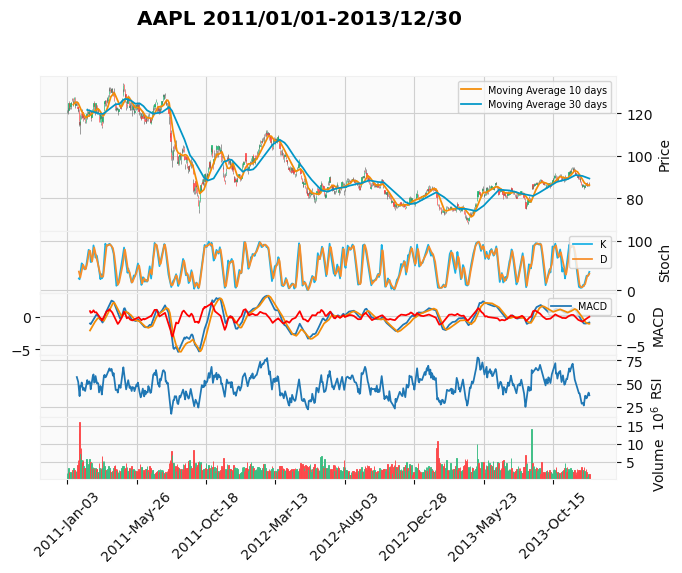

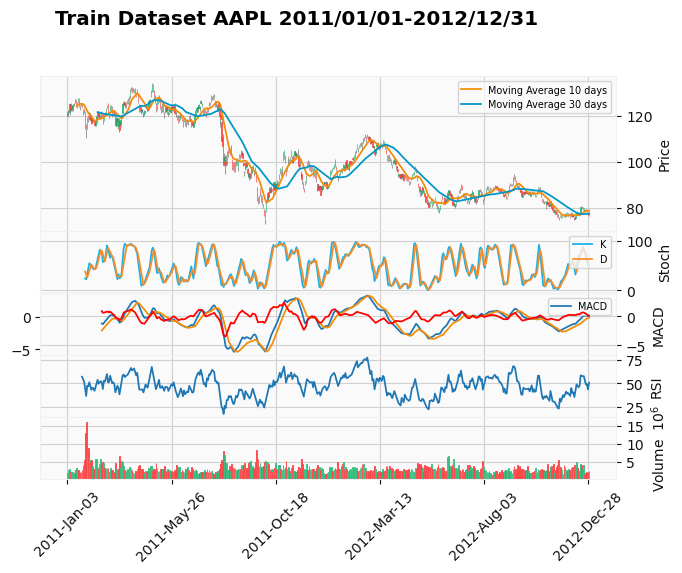

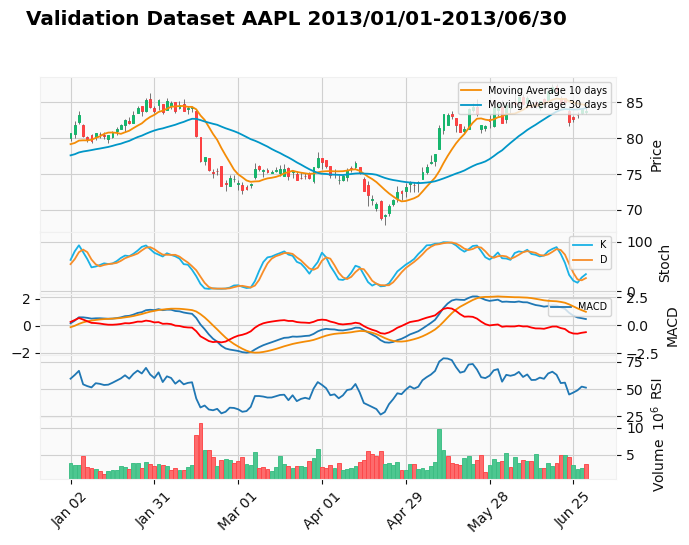

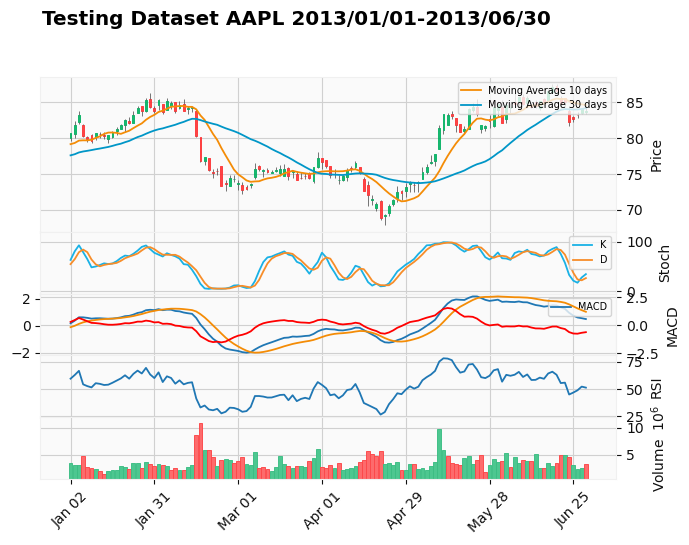

In [2]:
a = LoadFile()
a.chart('2011/01/01', '2013/12/30', '', 1)

# Training Data
a.chart('2011/01/01', '2012/12/31', 'Train Dataset',1)

# Validation Data
a.chart('2013/01/01', '2013/06/30', 'Validation Dataset',1)

# Testing Data
a.chart('2013/01/01', '2013/06/30', 'Testing Dataset',1)

##### Extract datasets and fill missing data

In [3]:
train = a.dataSplit('2011/01/01', '2012/12/31')
validate = a.dataSplit('2013/01/01', '2013/06/30')
test = a.dataSplit('2013/07/01', '2013/12/30')


for data in a.data.columns.values:
    train = a.fillNanData(train, data)

##### Get all data and fill missing data to perform the model's testing at the end

In [20]:
DataTestModel = a.data
for data in a.data.columns.values:
    DataTestModel = a.fillNanData(DataTestModel, data)

### RNN

30
TRAIN DATASET WITH DATASET


rnn ==>  Epoch:  61%|██████    | 610/1000 [01:22<00:52,  7.41it/s, Epoch=609, training_loss=6.95e-5, evaluation_loss=0.00691, patiente=1] 


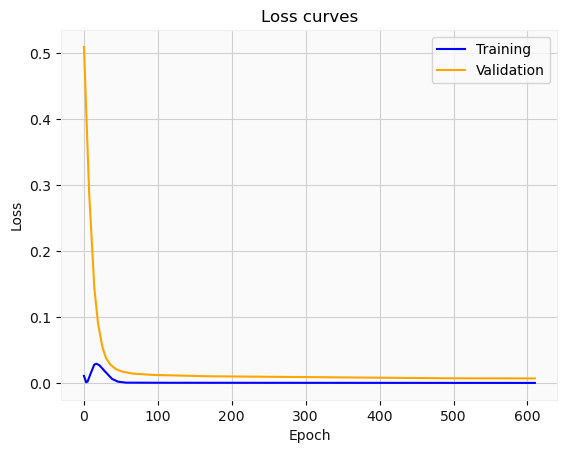

TEST DATASET WITH TESTING DATASET


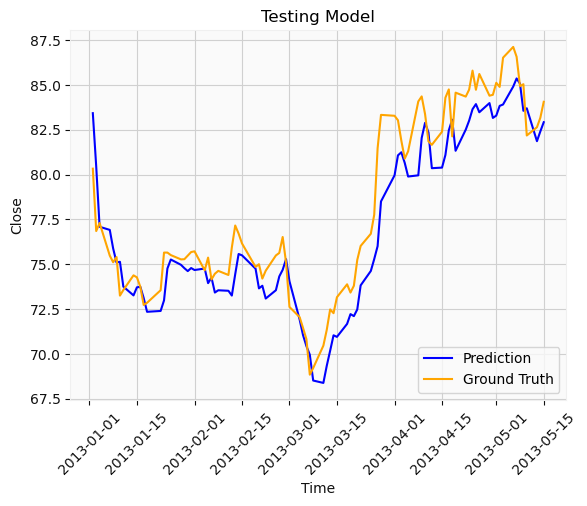

LOSS
loss: Model = rnn, Epoch = 610, Train = 0.00007, Validate = 0.00691, Test = 0.00973
TEST TRAINED MODEL WITH WHOLE DATASET


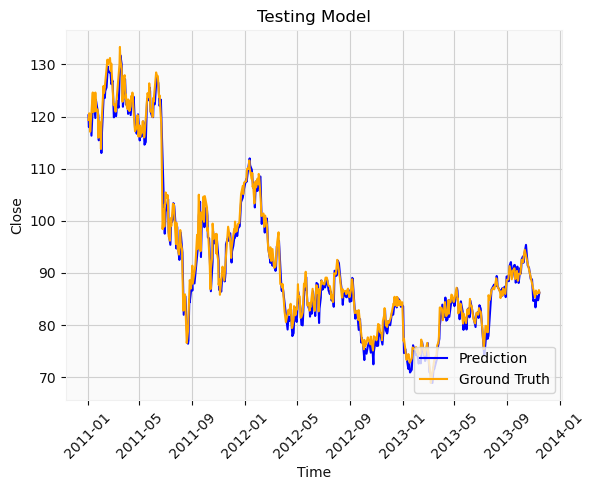

Loss : 0.000957506475970149


In [36]:
__LEARNING_RATE__ = 1e-4
__EPOCH__ = 1000
__HIDDEN_SIZE__ = 10
__LAYER_SIZE__ = 1
__BATCH_SIZE__ = 16
__PATIENTE__ = 2
__DROPOUT__ = 0

cleanVarCache()

rnn = RNN(train, test , validate, learning_rate = __LEARNING_RATE__, epoch = __EPOCH__, hidden_size = __HIDDEN_SIZE__, layer_size=__LAYER_SIZE__, batch_size = __BATCH_SIZE__, model = 'rnn', dropout= __DROPOUT__)
print('TRAIN DATASET WITH DATASET')
rnn.train_model(show = False, patiente= __PATIENTE__ )
print('TEST DATASET WITH TESTING DATASET')
rnn.test_model()
print('LOSS')
rnn.printLossValues()
print('TEST TRAINED MODEL WITH WHOLE DATASET')
rnn.plotResultComplete(DataTestModel)

### LSTM

30
TRAIN DATASET WITH DATASET


lstm ==>  Epoch: 100%|██████████| 1000/1000 [04:40<00:00,  3.57it/s, Epoch=999, training_loss=8.53e-5, evaluation_loss=0.00421, patiente=0]


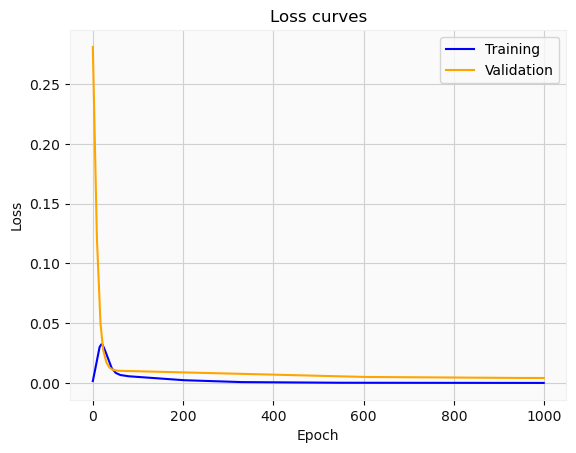

TEST DATASET WITH TESTING DATASET


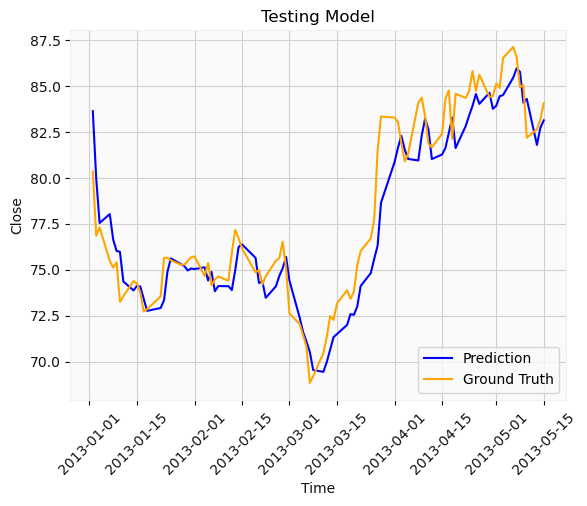

LOSS
loss: Model = lstm, Epoch = 999, Train = 0.00009, Validate = 0.00421, Test = 0.00735
TEST TRAINED MODEL WITH WHOLE DATASET


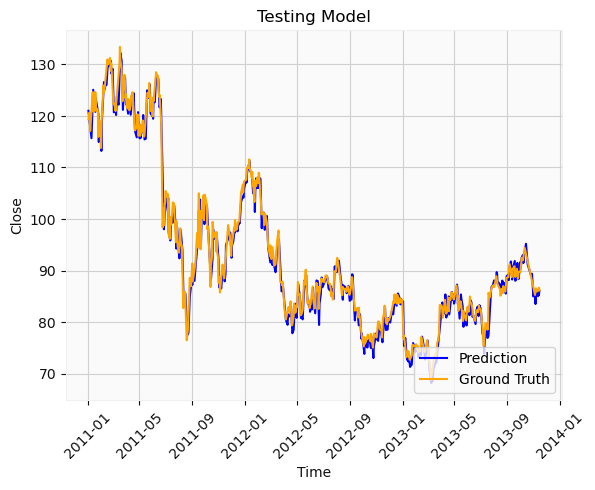

Loss : 0.0008740096818655729


In [37]:
__LEARNING_RATE__ = 1e-4
__EPOCH__ = 1000
__HIDDEN_SIZE__ = 10
__LAYER_SIZE__ = 1
__BATCH_SIZE__ = 16
__PATIENTE__ = 2
__DROPOUT__ = 0

cleanVarCache()

lstm = RNN(train, test , validate, learning_rate = __LEARNING_RATE__, epoch = __EPOCH__, hidden_size = __HIDDEN_SIZE__, layer_size=__LAYER_SIZE__, batch_size = __BATCH_SIZE__, model = 'lstm' , dropout= __DROPOUT__)
print('TRAIN DATASET WITH DATASET')
lstm.train_model(show = False, patiente= __PATIENTE__ )
print('TEST DATASET WITH TESTING DATASET')
lstm.test_model()
print('LOSS')
lstm.printLossValues()
print('TEST TRAINED MODEL WITH WHOLE DATASET')
lstm.plotResultComplete(DataTestModel)

### GRU

30
TRAIN DATASET WITH DATASET


gru ==>  Epoch: 100%|██████████| 1000/1000 [04:52<00:00,  3.42it/s, Epoch=999, training_loss=0.000193, evaluation_loss=0.00432, patiente=0]


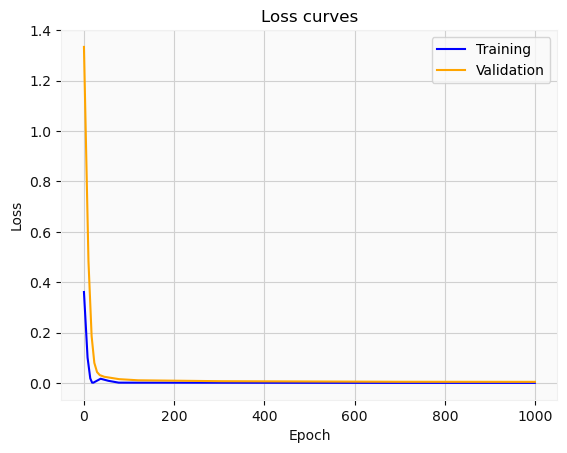

TEST DATASET WITH TESTING DATASET


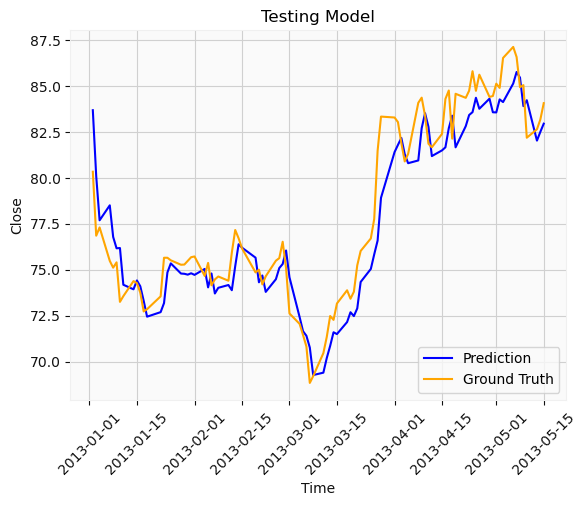

LOSS
loss: Model = gru, Epoch = 999, Train = 0.00019, Validate = 0.00432, Test = 0.00732
TEST TRAINED MODEL WITH WHOLE DATASET


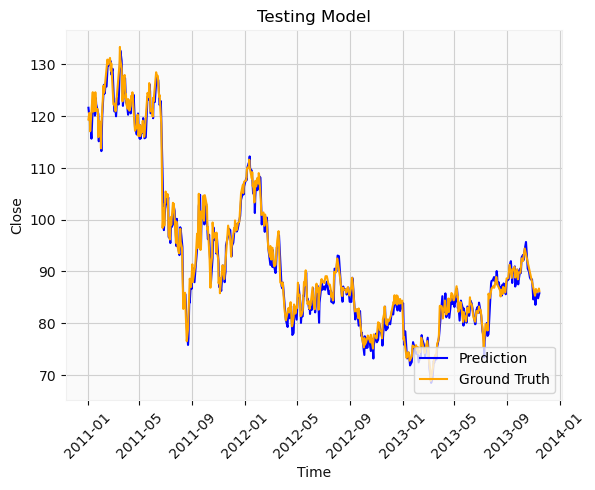

Loss : 0.0008679454331286252


In [32]:
__LEARNING_RATE__ = 1e-4
__EPOCH__ = 1000
__HIDDEN_SIZE__ = 10
__LAYER_SIZE__ = 1
__BATCH_SIZE__ = 16
__PATIENTE__ = 2
__DROPOUT__ = 0

cleanVarCache()

gru = RNN(train, test , validate, learning_rate = __LEARNING_RATE__, epoch = __EPOCH__, hidden_size = __HIDDEN_SIZE__, layer_size=__LAYER_SIZE__, batch_size = __BATCH_SIZE__, model = 'gru',  dropout= __DROPOUT__)
print('TRAIN DATASET WITH DATASET')
gru.train_model(show = False, patiente= __PATIENTE__ )
print('TEST DATASET WITH TESTING DATASET')
gru.test_model()
print('LOSS')
gru.printLossValues()
print('TEST TRAINED MODEL WITH WHOLE DATASET')
gru.plotResultComplete(DataTestModel)

##### Testing RNN LSTM and GRU with EPOCH = 300

##### RNN

30
TRAIN DATASET WITH DATASET


rnn ==>  Epoch: 100%|██████████| 300/300 [00:37<00:00,  7.98it/s, Epoch=299, training_loss=0.00012, evaluation_loss=0.00633, patiente=0] 


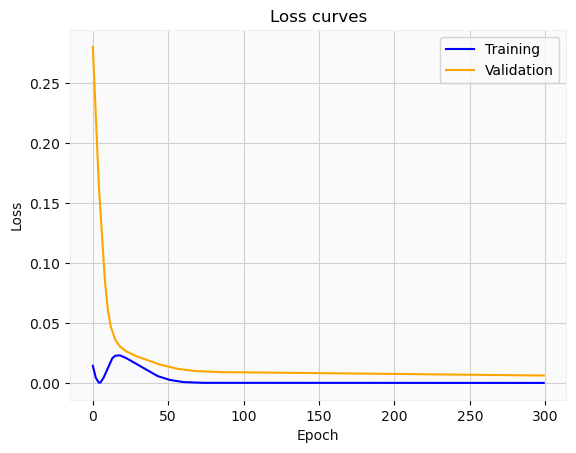

TEST DATASET WITH TESTING DATASET


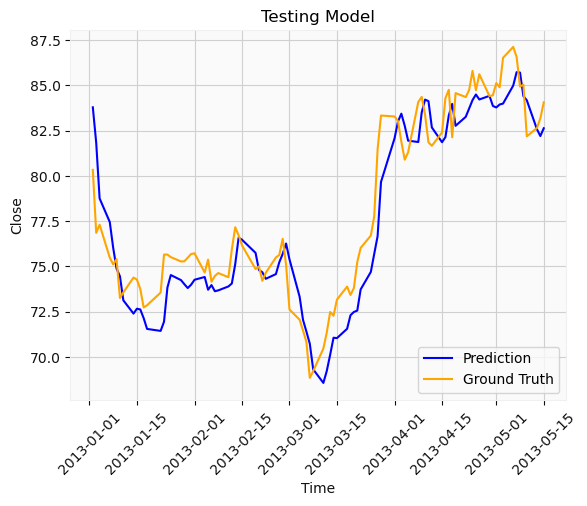

LOSS
loss: Model = rnn, Epoch = 299, Train = 0.00012, Validate = 0.00633, Test = 0.00861
TEST TRAINED MODEL WITH WHOLE DATASET


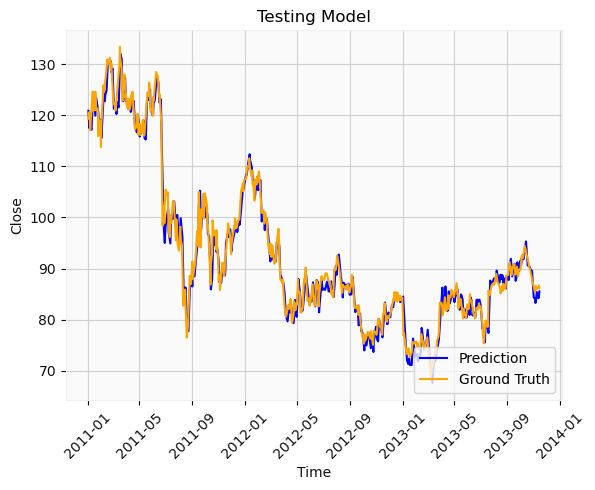

Loss : 0.0010924121597781777


In [21]:
__LEARNING_RATE__ = 1e-4
__EPOCH__ = 300
__HIDDEN_SIZE__ = 10
__LAYER_SIZE__ = 1
__BATCH_SIZE__ = 16
__PATIENTE__ = 20000
__DROPOUT__ = 0

cleanVarCache()

rnn = RNN(train, test , validate, learning_rate = __LEARNING_RATE__, epoch = __EPOCH__, hidden_size = __HIDDEN_SIZE__, layer_size=__LAYER_SIZE__, batch_size = __BATCH_SIZE__, model = 'rnn', dropout= __DROPOUT__)
print('TRAIN DATASET WITH DATASET')
rnn.train_model(show = False, patiente= __PATIENTE__ )
print('TEST DATASET WITH TESTING DATASET')
rnn.test_model()
print('LOSS')
rnn.printLossValues()
print('TEST TRAINED MODEL WITH WHOLE DATASET')
rnn.plotResultComplete(DataTestModel)

##### LSTM

30
TRAIN DATASET WITH DATASET


lstm ==>  Epoch: 100%|██████████| 300/300 [01:21<00:00,  3.67it/s, Epoch=299, training_loss=0.000492, evaluation_loss=0.015, patiente=0]   


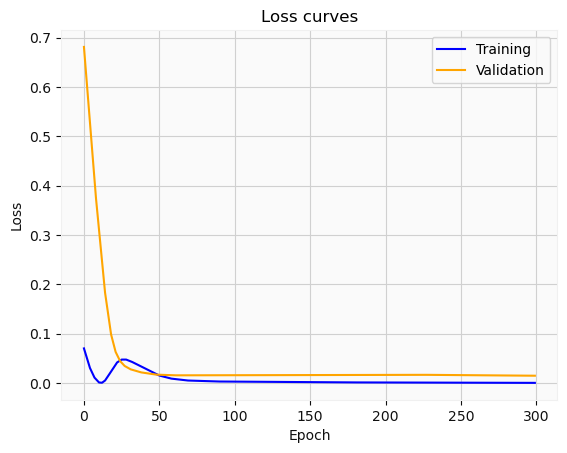

TEST DATASET WITH TESTING DATASET


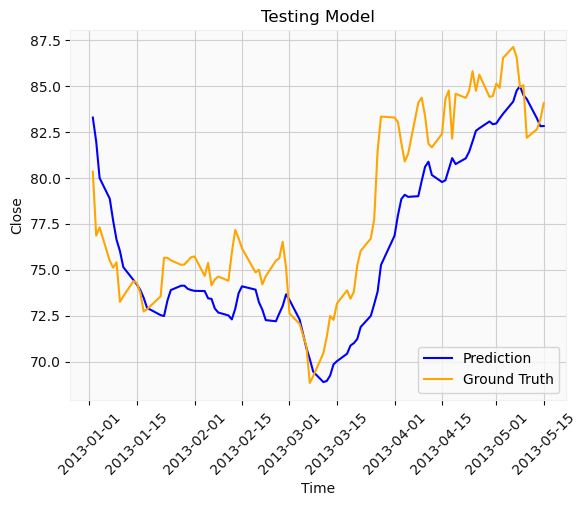

LOSS
loss: Model = lstm, Epoch = 299, Train = 0.00049, Validate = 0.01497, Test = 0.02446
TEST TRAINED MODEL WITH WHOLE DATASET


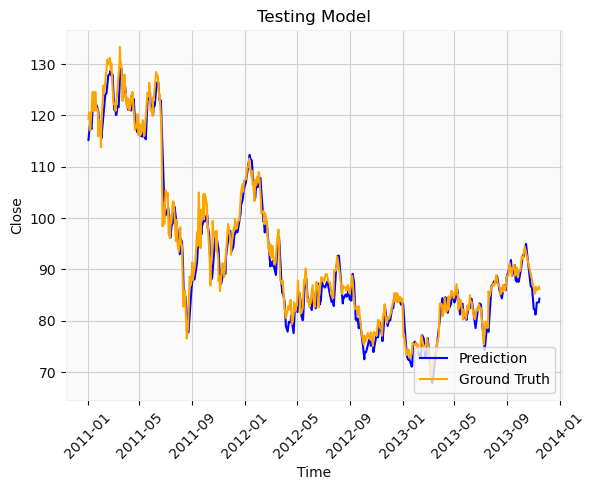

Loss : 0.001353685511276126


In [22]:
cleanVarCache()

lstm = RNN(train, test , validate, learning_rate = __LEARNING_RATE__, epoch = __EPOCH__, hidden_size = __HIDDEN_SIZE__, layer_size=__LAYER_SIZE__, batch_size = __BATCH_SIZE__, model = 'lstm' , dropout= __DROPOUT__)
print('TRAIN DATASET WITH DATASET')
lstm.train_model(show = False, patiente= __PATIENTE__ )
print('TEST DATASET WITH TESTING DATASET')
lstm.test_model()
print('LOSS')
lstm.printLossValues()
print('TEST TRAINED MODEL WITH WHOLE DATASET')
lstm.plotResultComplete(DataTestModel)

##### GRU

30
TRAIN DATASET WITH DATASET


gru ==>  Epoch: 100%|██████████| 300/300 [01:27<00:00,  3.43it/s, Epoch=299, training_loss=0.000113, evaluation_loss=0.0164, patiente=0]


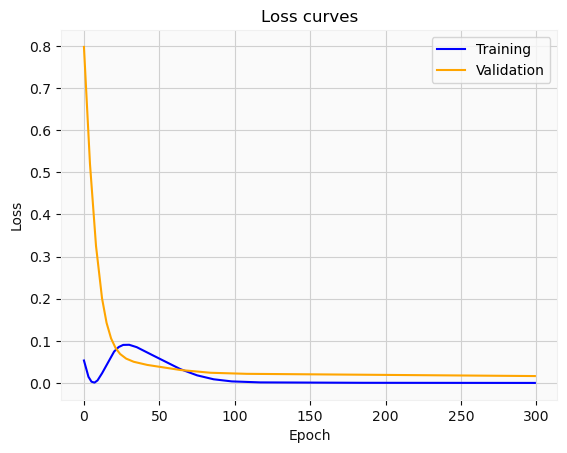

TEST DATASET WITH TESTING DATASET


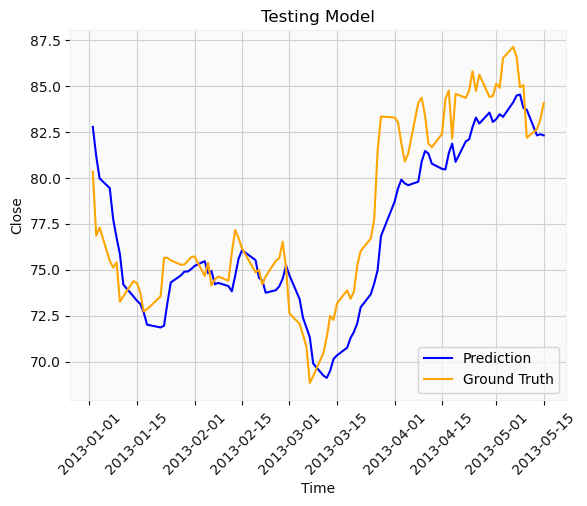

LOSS
loss: Model = gru, Epoch = 299, Train = 0.00011, Validate = 0.01641, Test = 0.01593
TEST TRAINED MODEL WITH WHOLE DATASET


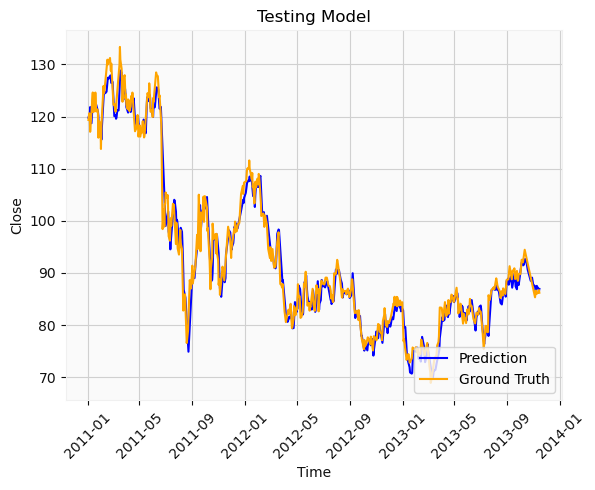

Loss : 0.0012572755804285407


In [23]:
cleanVarCache()

gru = RNN(train, test , validate, learning_rate = __LEARNING_RATE__, epoch = __EPOCH__, hidden_size = __HIDDEN_SIZE__, layer_size=__LAYER_SIZE__, batch_size = __BATCH_SIZE__, model = 'gru',  dropout= __DROPOUT__)
print('TRAIN DATASET WITH DATASET')
gru.train_model(show = False, patiente= __PATIENTE__ )
print('TEST DATASET WITH TESTING DATASET')
gru.test_model()
print('LOSS')
gru.printLossValues()
print('TEST TRAINED MODEL WITH WHOLE DATASET')
gru.plotResultComplete(DataTestModel)

#### Daily News for Stock Price Prediction

In [42]:
''' For DistilBERT: samller, faster, cheaper, lighter 40% less parameters than bert-base-uncased
    run 60% faster
    95% of BERT's performance as meassured on the GLUE language understanding benchmark. 
'''
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

'''
    Extract inforamtion from news
    type_extraction = ['title', 'content', 'title-content' ]
'''
content = 'title'
a.load_news(type = content)

'''
    Load model and tokenizer from BERT
'''
print('INIT BERT MODEL AND TOKENIZER')
a.initBert()

train_News = a.dataSplitNews('2011/01/01', '2012/12/31')
validate_News = a.dataSplitNews('2013/01/01', '2013/06/30')
test_News = a.dataSplitNews('2013/07/01', '2013/12/30')

newsTrain = train.join(train_News)
newsTest = test.join(test_News)
newsValidate = validate.join(validate_News)

newsTrain = a.fillNanDataNews(newsTrain, content)
newsTest = a.fillNanDataNews(newsTest, content)
newsValidate = a.fillNanDataNews(newsValidate, content)

'''
Process title, content or title + content with BERT model 
return BERT embeddings
'''
trainBert = a.embeddings_pretrain_BERT(newsTrain[content])
validateBert = a.embeddings_pretrain_BERT(newsValidate[content])
testBert = a.embeddings_pretrain_BERT(newsTest[content])

trainBertData = a.join_data_bert(newsTrain, trainBert, content)
validateBertData = a.join_data_bert(newsValidate, validateBert, content)
testBertData = a.join_data_bert(newsTest, testBert, content)

totalBert = pd.concat([trainBertData, validateBertData, testBertData])

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


INIT BERT MODEL AND TOKENIZER


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### RNN

179
TRAIN DATASET WITH DATASET


rnn ==>  Epoch:  19%|█▉        | 190/1000 [15:46<1:07:14,  4.98s/it, Epoch=189, training_loss=0.00135, evaluation_loss=0.00612, patiente=1]


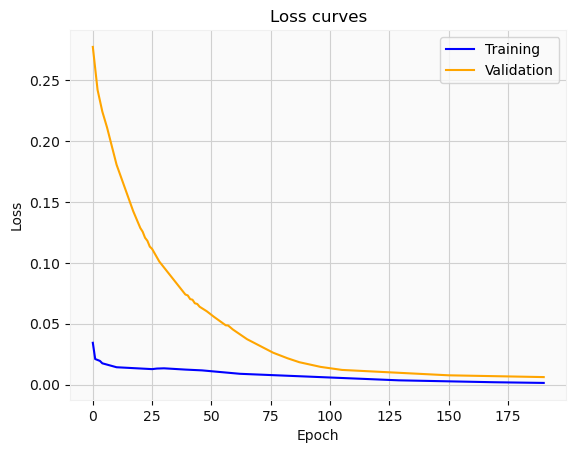

TEST DATASET WITH TESTING DATASET


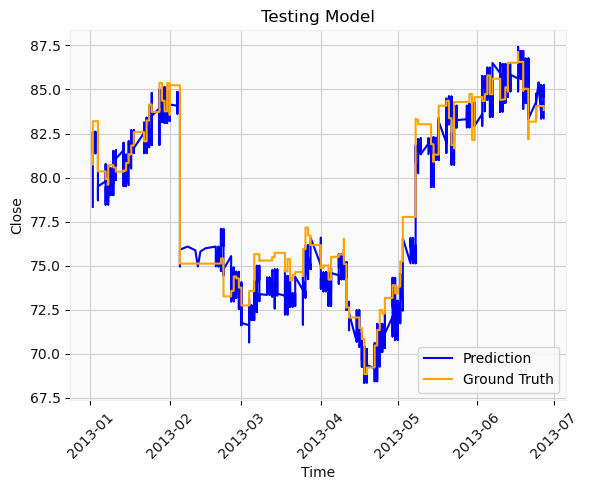

LOSS
loss: Model = rnn, Epoch = 190, Train = 0.00132, Validate = 0.00611, Test = 0.00406


In [8]:
__LEARNING_RATE_BERT__ = 1e-4
__EPOCH_BERT__ = 1000
__HIDDEN_SIZE_BERT__ = 20
__LAYER_SIZE_BERT__ = 1
__BATCH_SIZE_BERT__ = 200
__PATIENTE_BERT__ = 2
__DROPOUT__ = 0.2

cleanVarCache()

rnnBert = RNN(trainBertData, testBertData , validateBertData, learning_rate = __LEARNING_RATE_BERT__, epoch = __EPOCH_BERT__, hidden_size = __HIDDEN_SIZE_BERT__, layer_size=__LAYER_SIZE_BERT__, batch_size = __BATCH_SIZE_BERT__, model = 'rnn', dropout= __DROPOUT__)
print('TRAIN DATASET WITH DATASET')
rnnBert.train_model(show = False, patiente= __PATIENTE_BERT__ )
print('TEST DATASET WITH TESTING DATASET')
rnnBert.test_model()
print('LOSS')
rnnBert.printLossValues()


TEST TRAINED MODEL WITH WHOLE DATASET


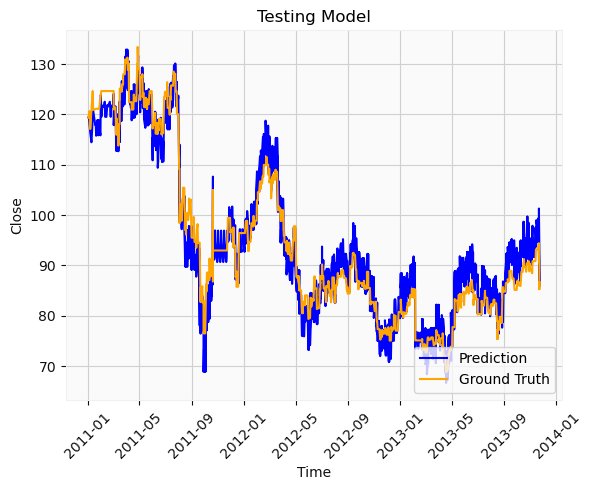

Loss : 0.002740522613748908


In [9]:
print('TEST TRAINED MODEL WITH WHOLE DATASET')
rnnBert.plotResultComplete(totalBert)

### LSTM

179
TRAIN DATASET WITH DATASET


lstm ==>  Epoch:  11%|█         | 110/1000 [16:15<2:11:35,  8.87s/it, Epoch=109, training_loss=0.000516, evaluation_loss=0.00871, patiente=19]


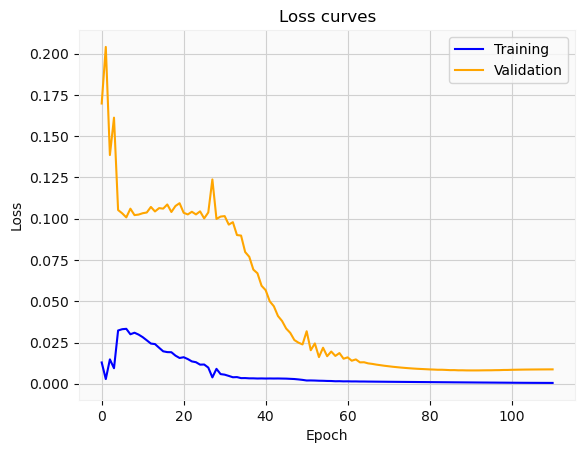

TEST DATASET WITH TESTING DATASET


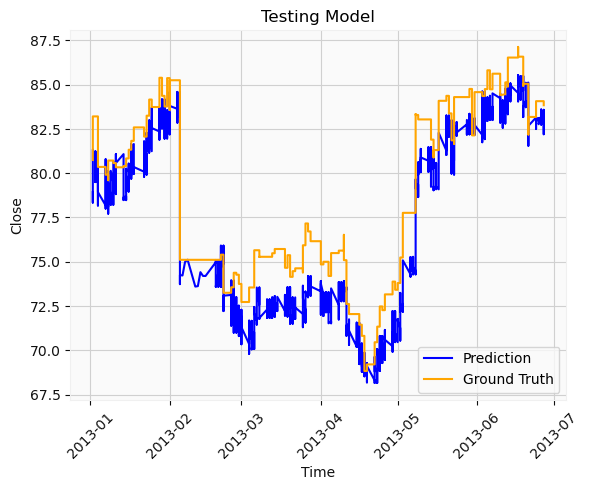

LOSS
loss: Model = lstm, Epoch = 110, Train = 0.00051, Validate = 0.00872, Test = 0.01194


In [25]:
__LEARNING_RATE_BERT__ = 1e-4
__EPOCH_BERT__ = 1000
__HIDDEN_SIZE_BERT__ = 20
__LAYER_SIZE_BERT__ = 1
__BATCH_SIZE_BERT__ = 200
__PATIENTE_BERT__ = 20
__DROPOUT__ = 0.2
__WEIGHT_DEKAY__ = 0

cleanVarCache()

lstmBert = RNN(trainBertData, testBertData , validateBertData, learning_rate = __LEARNING_RATE_BERT__, epoch = __EPOCH_BERT__, hidden_size = __HIDDEN_SIZE_BERT__, layer_size=__LAYER_SIZE_BERT__, batch_size = __BATCH_SIZE_BERT__, model = 'lstm', dropout=__DROPOUT__, weight_decay=__WEIGHT_DEKAY__)
print('TRAIN DATASET WITH DATASET')
lstmBert.train_model(show = False, patiente= __PATIENTE_BERT__ )
print('TEST DATASET WITH TESTING DATASET')
lstmBert.test_model()
print('LOSS')
lstmBert.printLossValues()


TEST TRAINED MODEL WITH WHOLE DATASET


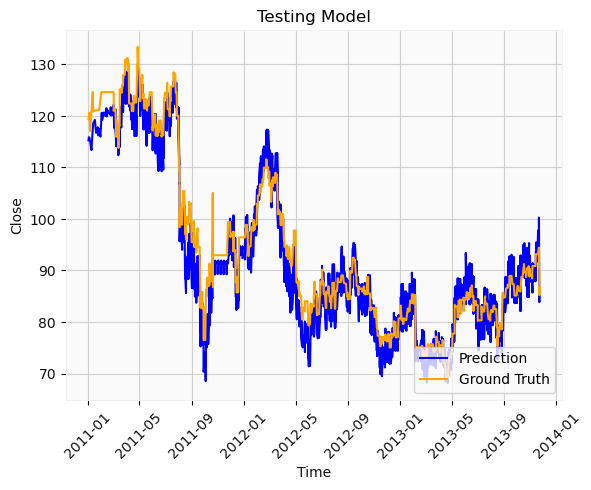

Loss : 0.003396348562091589


In [26]:
print('TEST TRAINED MODEL WITH WHOLE DATASET')
lstmBert.plotResultComplete(totalBert)

136
TRAIN DATASET WITH DATASET


lstm ==>  Epoch:  11%|█         | 111/1000 [20:18<2:42:41, 10.98s/it, Epoch=110, training_loss=0.000138, evaluation_loss=0.0131, patiente=19]


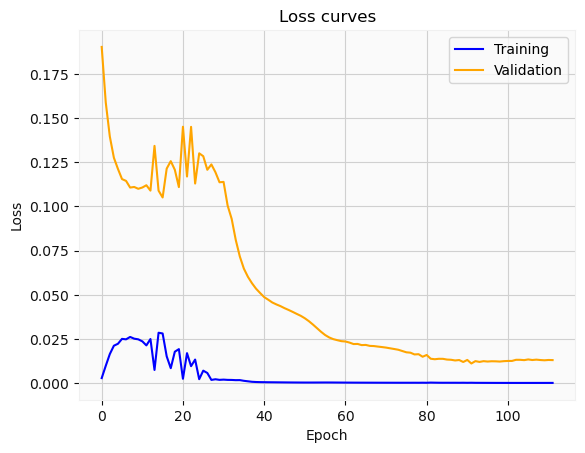

TEST DATASET WITH TESTING DATASET


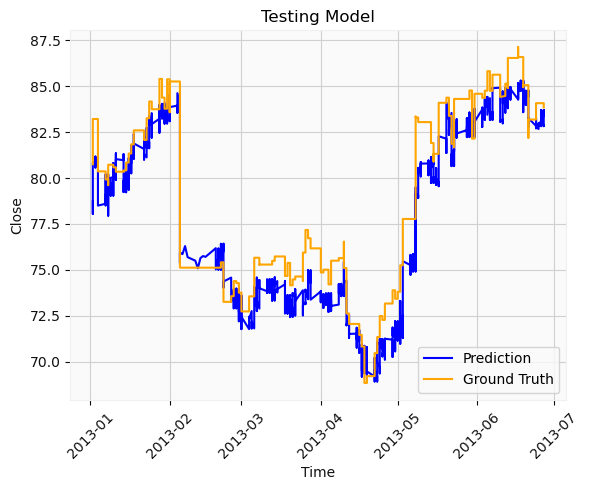

LOSS
loss: Model = lstm, Epoch = 111, Train = 0.00014, Validate = 0.01305, Test = 0.00645


In [39]:
__LEARNING_RATE_BERT__ = 1e-4
__EPOCH_BERT__ = 1000
__HIDDEN_SIZE_BERT__ = 30
__LAYER_SIZE_BERT__ = 1
__BATCH_SIZE_BERT__ = 264
__PATIENTE_BERT__ = 20
__DROPOUT__ = 0.2
__WEIGHT_DEKAY__ = 0

cleanVarCache()

lstmBert1 = RNN(trainBertData, testBertData , validateBertData, learning_rate = __LEARNING_RATE_BERT__, epoch = __EPOCH_BERT__, hidden_size = __HIDDEN_SIZE_BERT__, layer_size=__LAYER_SIZE_BERT__, batch_size = __BATCH_SIZE_BERT__, model = 'lstm', dropout=__DROPOUT__, weight_decay=__WEIGHT_DEKAY__)
print('TRAIN DATASET WITH DATASET')
lstmBert1.train_model(show = False, patiente= __PATIENTE_BERT__ )
print('TEST DATASET WITH TESTING DATASET')
lstmBert1.test_model()
print('LOSS')
lstmBert1.printLossValues()

TEST TRAINED MODEL WITH WHOLE DATASET


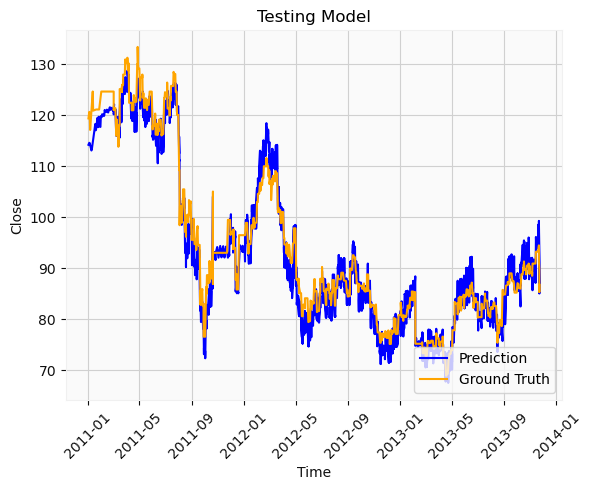

Loss : 0.0021436051465570927


In [40]:
print('TEST TRAINED MODEL WITH WHOLE DATASET')
lstmBert1.plotResultComplete(totalBert)

### GRU BERT

179
TRAIN DATASET WITH DATASET


gru ==>  Epoch:  21%|██        | 210/1000 [28:41<1:47:56,  8.20s/it, Epoch=209, training_loss=0.000456, evaluation_loss=0.01, patiente=9]   


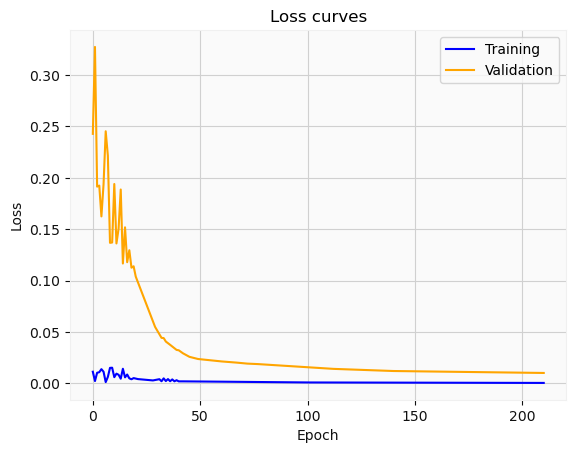

TEST DATASET WITH TESTING DATASET


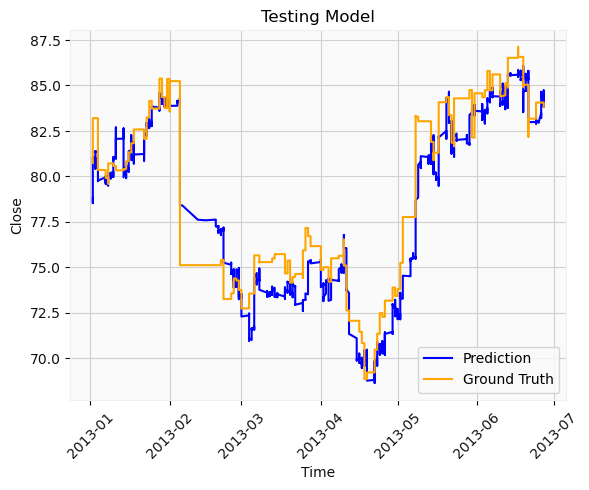

LOSS
loss: Model = gru, Epoch = 210, Train = 0.00044, Validate = 0.01014, Test = 0.00451


In [34]:
__LEARNING_RATE_BERT__ = 1e-4
__EPOCH_BERT__ = 1000
__HIDDEN_SIZE_BERT__ = 20
__LAYER_SIZE_BERT__ = 1
__BATCH_SIZE_BERT__ = 200
__PATIENTE_BERT__ = 10
__DROPOUT__ = 0.2
__WEIGHT_DEKAY__ = 1e-9


cleanVarCache()

gruBert = RNN(trainBertData, testBertData , validateBertData, learning_rate = __LEARNING_RATE_BERT__, epoch = __EPOCH_BERT__, hidden_size = __HIDDEN_SIZE_BERT__, layer_size=__LAYER_SIZE_BERT__, batch_size = __BATCH_SIZE_BERT__, model = 'gru', dropout=__DROPOUT__, weight_decay=__WEIGHT_DEKAY__)
print('TRAIN DATASET WITH DATASET')
gruBert.train_model(show = False, patiente= __PATIENTE_BERT__ )
print('TEST DATASET WITH TESTING DATASET')
gruBert.test_model()
print('LOSS')
gruBert.printLossValues()


TEST TRAINED MODEL WITH WHOLE DATASET


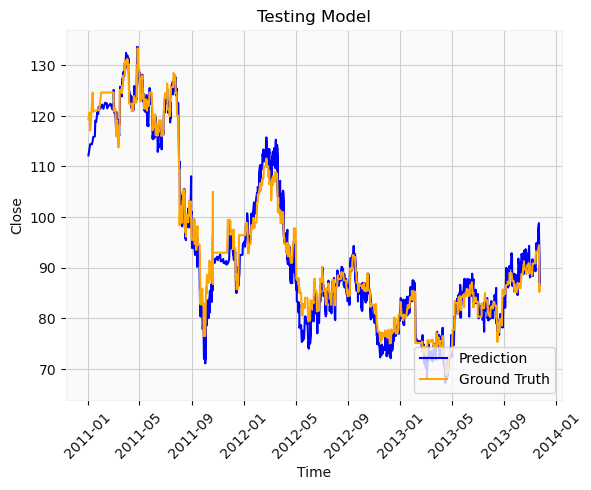

Loss : 0.001596209709532559


In [35]:
print('TEST TRAINED MODEL WITH WHOLE DATASET')
gruBert.plotResultComplete(totalBert)